In [1]:
!pip install shap lime joblib scikit-learn matplotlib pandas numpy


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=0ba291ff7f8237730c0a34f4f3ee3714200089d68ff7fe6a0b23e2830ecdfa89
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


In [2]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, precision_score, recall_score
import joblib
import json
import matplotlib.pyplot as plt

import shap
from lime.lime_tabular import LimeTabularExplainer

# SHAP init for Colab
shap.initjs()


In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [13]:
DATA_PATH = "/content/drive/MyDrive/Credict Risk/credit_risk_synthetic.csv"

In [21]:
def load_and_preprocess(path):
    df = pd.read_csv(path)

    y = df["default"].astype(int)
    X = df.drop(columns=["default"])

    numeric_features = [
        "loan_amnt","int_rate","annual_inc","dti",
        "delinq_2yrs","revol_util","total_acc","age"
    ]
    categorical_features = [c for c in X.columns if c not in numeric_features]

    numeric_transformer = Pipeline([
        ("scaler", StandardScaler())
    ])

    categorical_transformer = Pipeline([
        ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
    ])

    preprocessor = ColumnTransformer(transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ])

    return X, y, preprocessor, numeric_features, categorical_features


In [22]:
def train_and_save_model(X_train, y_train, preprocessor, save_path="/content/drive/MyDrive/Credict Risk/model.joblib"):
    clf = Pipeline([
        ("pre", preprocessor),
        ("clf", GradientBoostingClassifier(
            n_estimators=200, learning_rate=0.05, max_depth=4, random_state=42
        ))
    ])

    clf.fit(X_train, y_train)
    joblib.dump(clf, save_path)
    return clf


In [23]:
def evaluate_model(clf, X_test, y_test):
    y_pred_proba = clf.predict_proba(X_test)[:,1]
    y_pred = (y_pred_proba >= 0.5).astype(int)

    auc = roc_auc_score(y_test, y_pred_proba)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)

    return {"auc": float(auc), "precision": float(precision), "recall": float(recall)}


In [24]:
def shap_analysis(clf, X_train, X_test, numeric_features, categorical_features, out_prefix="shap"):
    pre = clf.named_steps["pre"]

    X_train_trans = pre.transform(X_train)
    model = clf.named_steps["clf"]

    # Construct feature names
    feature_names = numeric_features.copy()

    for name, trans, cols in pre.transformers_:
        if name == "cat":
            ohe = trans.named_steps["ohe"]
            cat_names = ohe.get_feature_names_out(categorical_features).tolist()
            feature_names += cat_names

    explainer = shap.Explainer(model.predict, X_train_trans, feature_names=feature_names)
    shap_values = explainer(pre.transform(X_test))

    shap.summary_plot(shap_values, features=pre.transform(X_test), feature_names=feature_names)

    plt.savefig(f"/content/drive/MyDrive/Credict Risk/{out_prefix}_summary.png")
    print(f"Saved SHAP summary plot to {out_prefix}_summary.png")
    plt.close()

    return shap_values


In [25]:
def lime_analysis(clf, X_train, X_test, numeric_features, categorical_features, out_prefix="lime"):
    pre = clf.named_steps["pre"]
    X_train_trans = pre.transform(X_train)
    model = clf.named_steps["clf"]

    feature_names = numeric_features.copy()
    ohe = None
    for name, trans, cols in pre.transformers_:
        if name == "cat":
            ohe = trans.named_steps["ohe"]

    if ohe is not None:
        feature_names += ohe.get_feature_names_out(categorical_features).tolist()

    explainer = LimeTabularExplainer(
        X_train_trans,
        feature_names=feature_names,
        class_names=["no_default", "default"],
        discretize_continuous=True
    )

    instances = X_test.iloc[[0,1,2]]
    instances_trans = pre.transform(instances)

    for i, inst in enumerate(instances_trans):
        exp = explainer.explain_instance(inst, model.predict_proba, num_features=10)
        fname = f"/content/drive/MyDrive/Credict Risk/{out_prefix}_exp_{i}.html"
        exp.save_to_file(fname)
        print(f"LIME explanation saved to {fname}")


In [26]:
def generate_case_reports(clf, X, indices, out_prefix="case"):
    pre = clf.named_steps["pre"]
    model = clf.named_steps["clf"]

    X_pre = pre.transform(X.iloc[indices])

    explainer = shap.Explainer(model.predict, pre.transform(X))
    shap_vals = explainer(X_pre)

    reports = []
    for i, sv in enumerate(shap_vals):
        fname = f"/content/drive/MyDrive/Credict Risk/{out_prefix}_shap_case_{i}.png"
        shap.plots.waterfall(sv, show=True)
        plt.savefig(fname)
        plt.close()
        reports.append({"case": i, "shap_plot": fname})

    return reports


Model metrics: {'auc': 0.536122709930047, 'precision': 0.5527638190954773, 'recall': 0.6576980568011959}


PermutationExplainer explainer: 1251it [01:06, 16.56it/s]                          


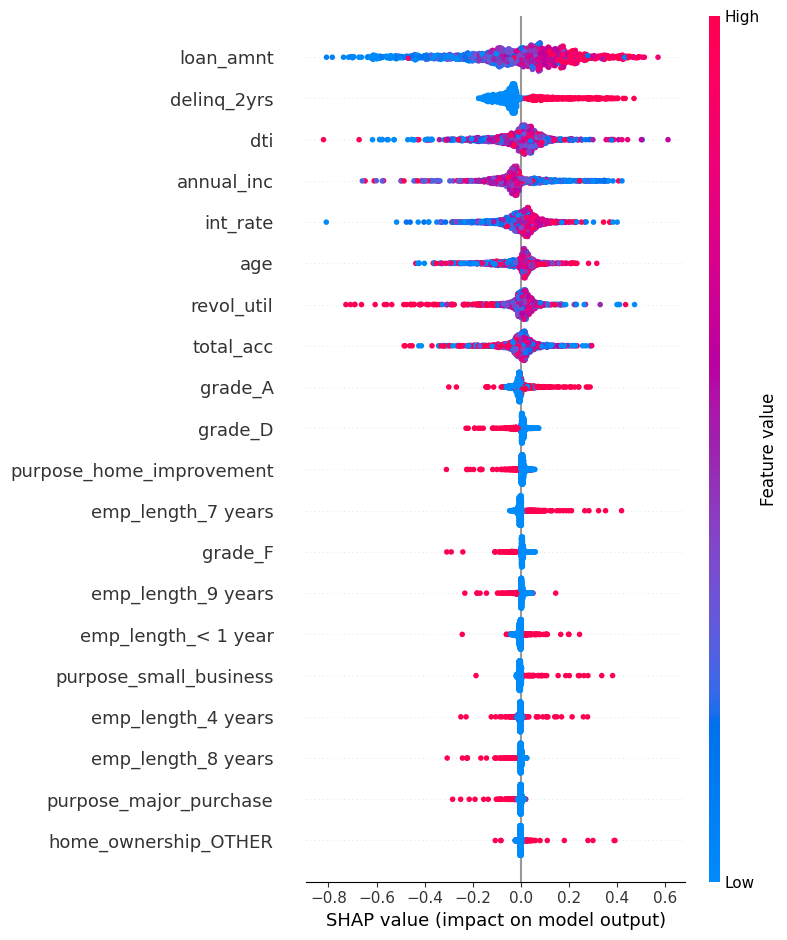

Saved SHAP summary plot to shap_summary.png
LIME explanation saved to /content/drive/MyDrive/Credict Risk/lime_exp_0.html
LIME explanation saved to /content/drive/MyDrive/Credict Risk/lime_exp_1.html
LIME explanation saved to /content/drive/MyDrive/Credict Risk/lime_exp_2.html


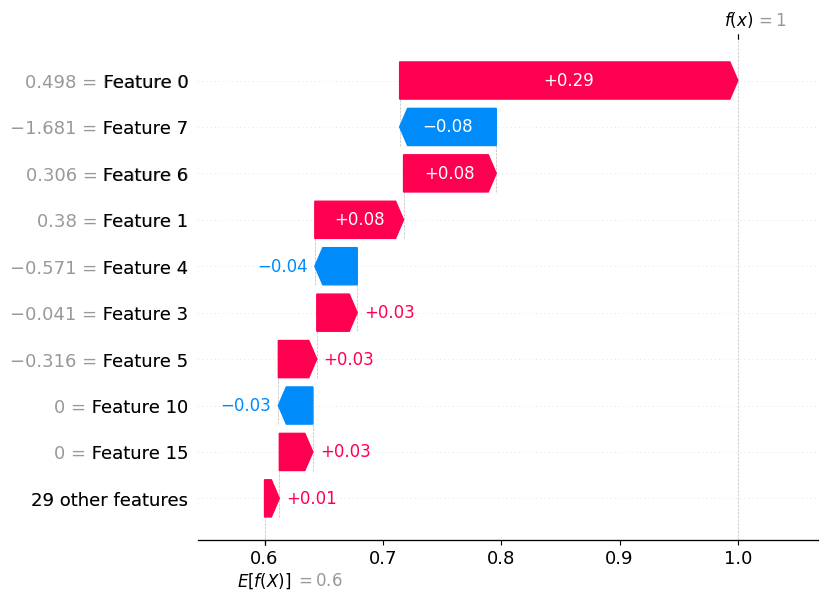

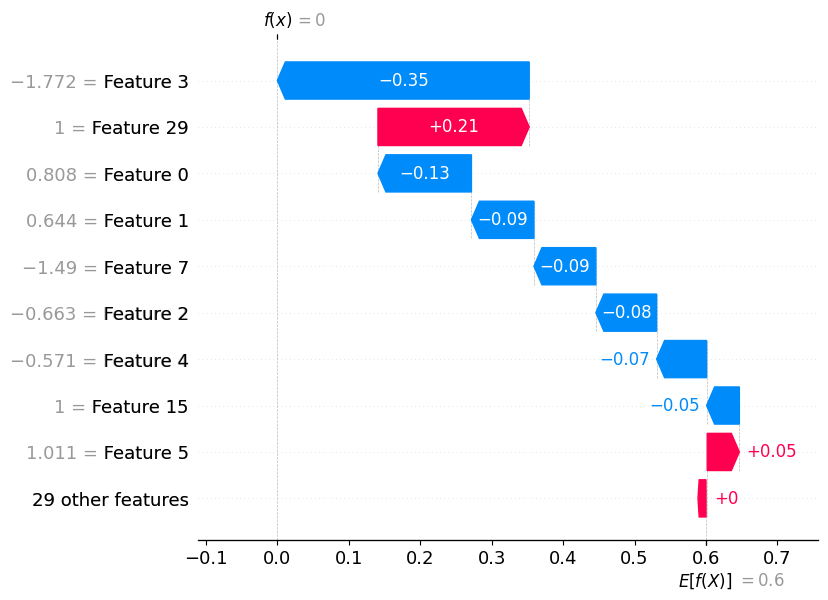

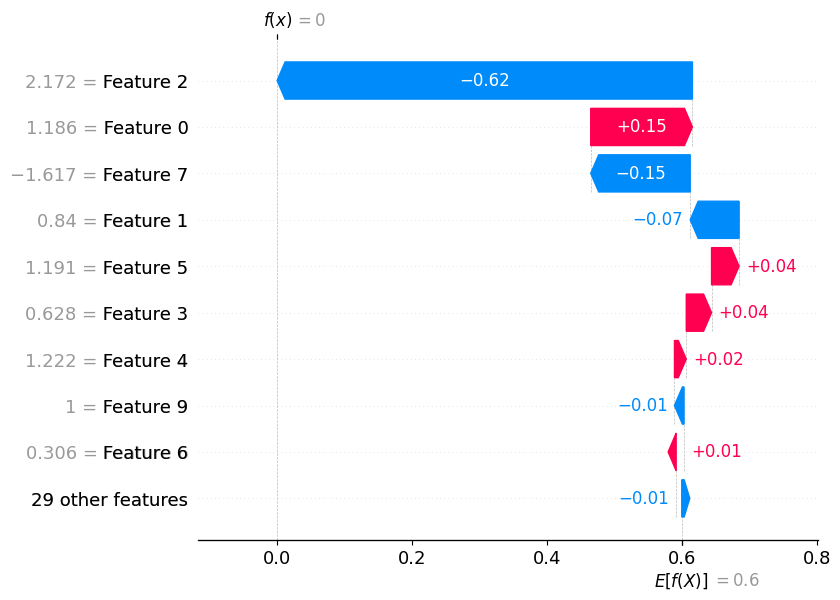

Done. Check generated files and images.


In [27]:
X, y, preprocessor, numeric_features, categorical_features = load_and_preprocess(DATA_PATH)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

clf = train_and_save_model(X_train, y_train, preprocessor, save_path="/content/drive/MyDrive/Credict Risk/model.joblib")

metrics = evaluate_model(clf, X_test, y_test)
print("Model metrics:", metrics)

with open("metrics.json", "w") as f:
    json.dump(metrics, f, indent=2)

# Run SHAP
shap_values = shap_analysis(
    clf, X_train, X_test, numeric_features, categorical_features
)

# Run LIME
lime_analysis(
    clf, X_train, X_test, numeric_features, categorical_features
)

# Case studies
profiles_idx = [0,1,2]
case_reports = generate_case_reports(
    clf, X_test.reset_index(drop=True), profiles_idx
)

print("Done. Check generated files and images.")
